In [19]:
import torch
import random
import numpy as np

from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.slim import slim
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

In [20]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [44]:
from neuromancer.psl.base import ODE_Autonomous, cast_backend
import numpy as np

class Pendulum(ODE_Autonomous):

    @property
    def params(self):
        variables = {'x0': [-2, -2]} # Initial condition
        constants = {'ts': 0.1} # Time step for numerical simulation
        parameters = {'g': -1., # parameters of the hamiltonian system
                      'l': 1.}
        meta = {}
        return variables, constants, parameters, meta
        
    @cast_backend
    def equations(self, t, x):
        return [x[1], (self.g/self.l)*np.sin(x[0])]

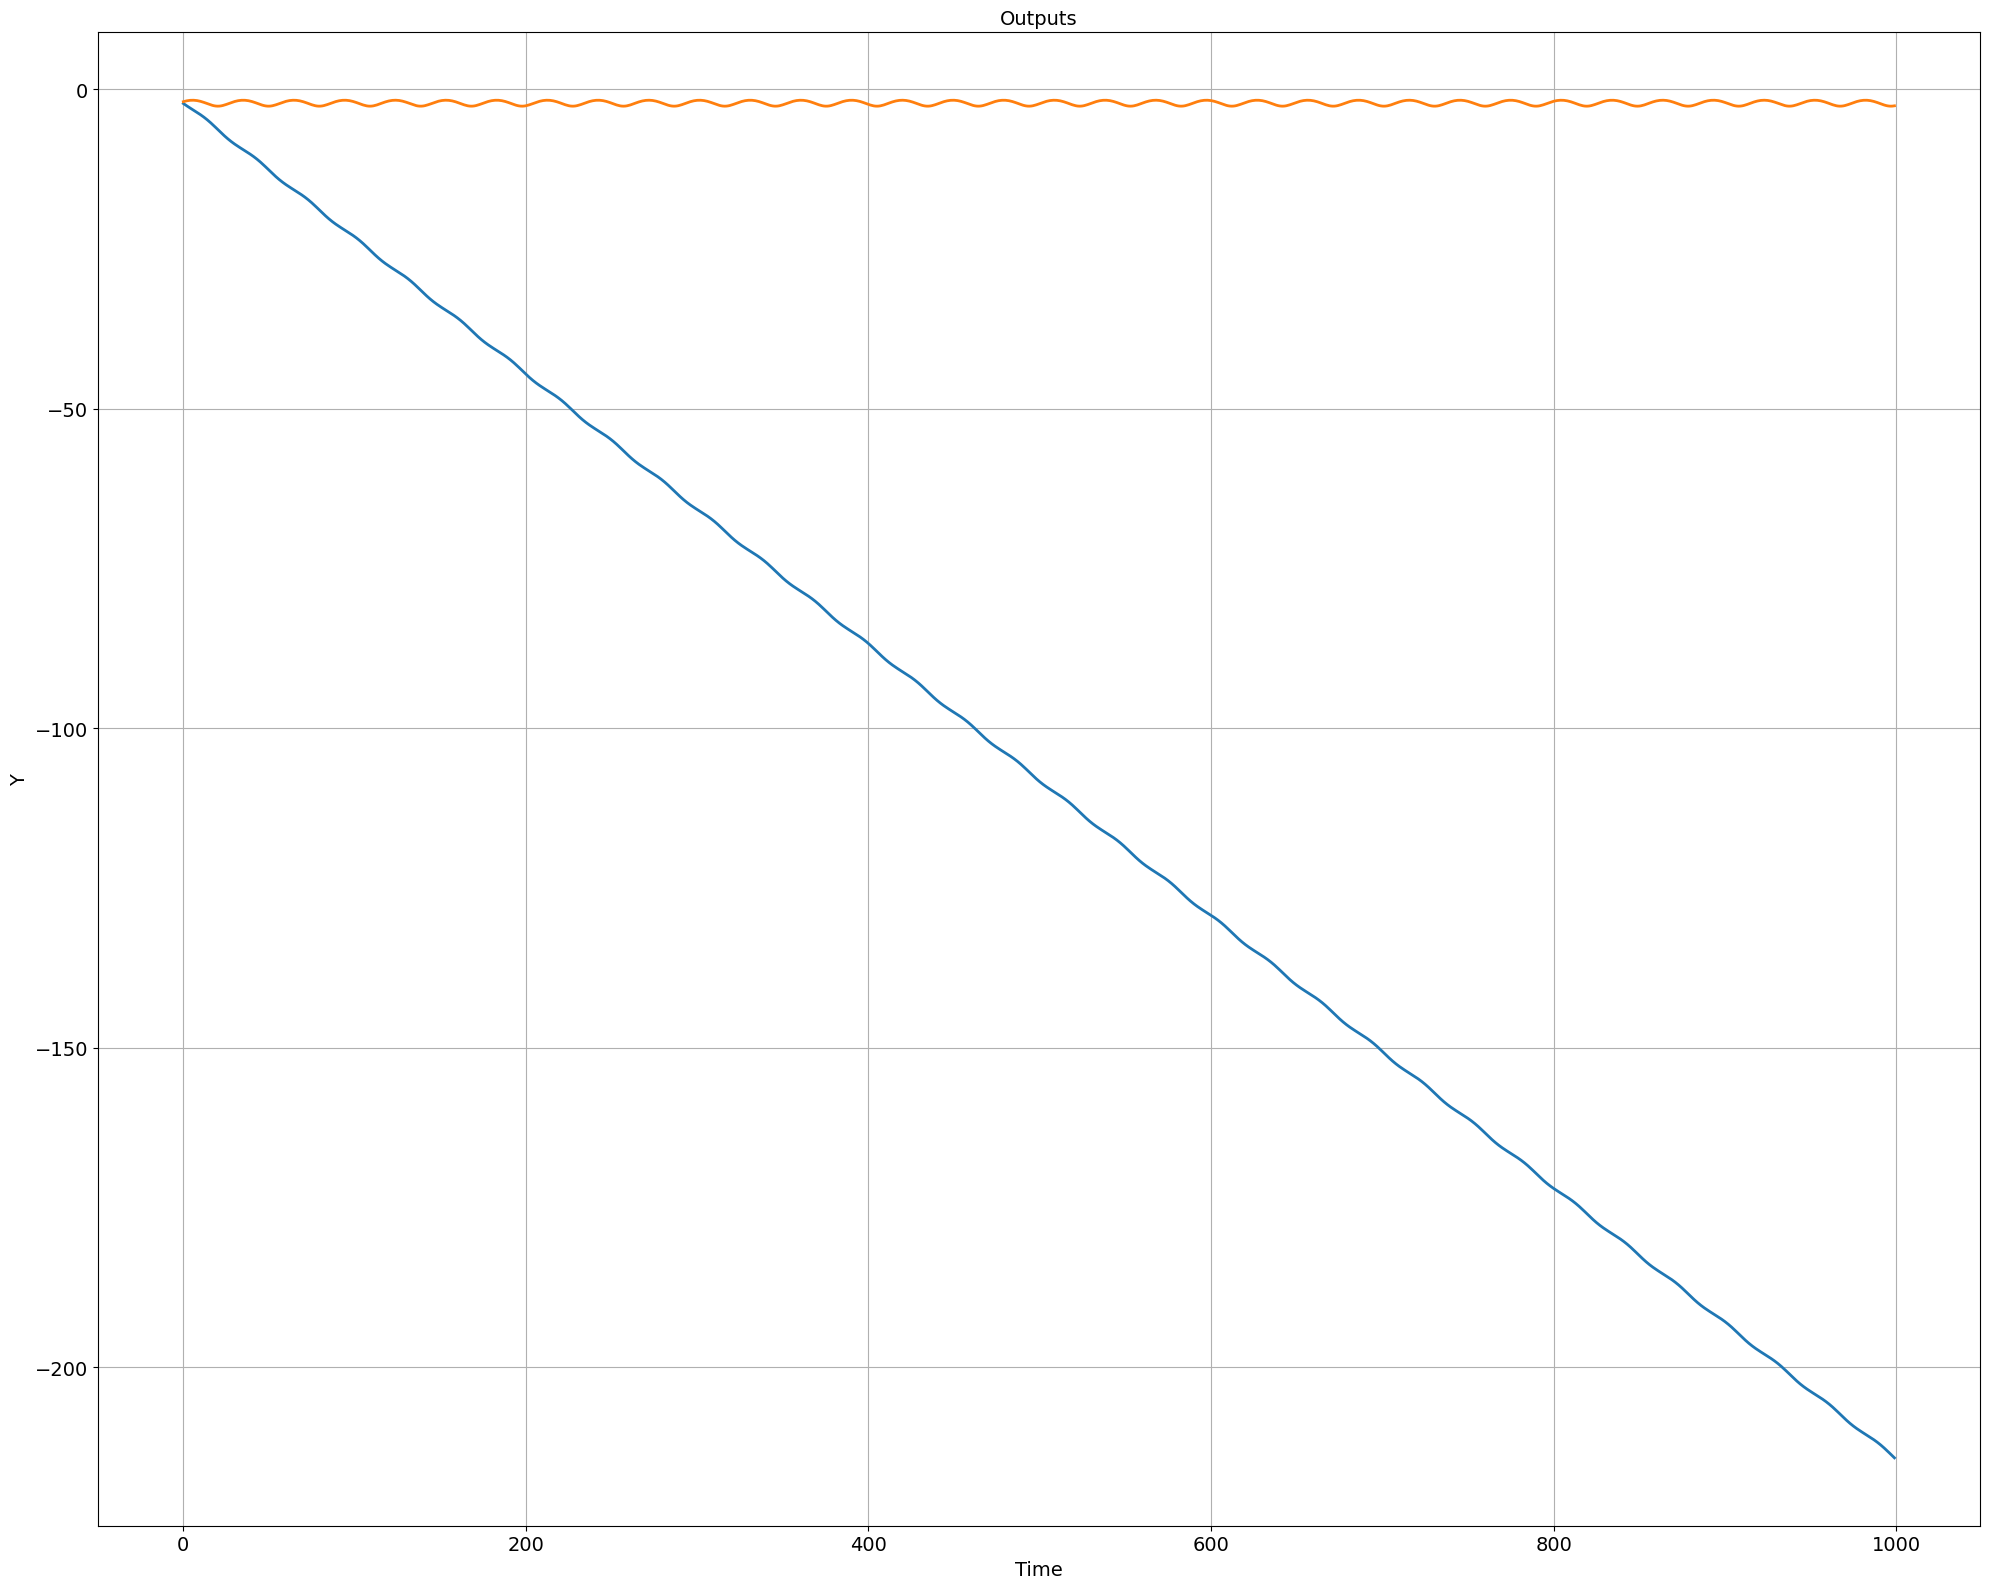

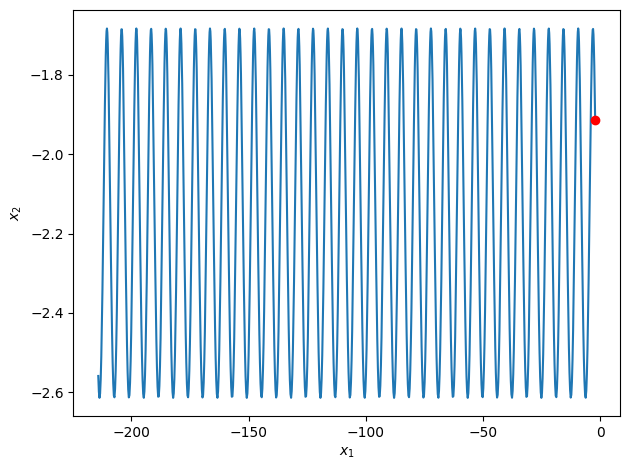

In [45]:
# %%  ground truth system
modelSystem = Pendulum()
ts = modelSystem.ts
nx = modelSystem.nx
ny = modelSystem.ny
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'])
plot.pltPhase(X=raw['Y'])

In [46]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    ny = sys.ny
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainY = train_sim['Y'][:length].reshape(nbatch, nsteps, ny)
    trainY = torch.tensor(trainY, dtype=torch.float32)
    train_data = DictDataset({'Y': trainY, 'Y0': trainY[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devY = dev_sim['Y'][:length].reshape(nbatch, nsteps, ny)
    devY = torch.tensor(devY, dtype=torch.float32)
    dev_data = DictDataset({'Y': devY, 'Y0': devY[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testY = test_sim['Y'][:length].reshape(1, nsim, ny)
    testY = torch.tensor(testY, dtype=torch.float32)
    test_data = {'Y': testY, 'Y0': testY[:, 0:1, :], 'name': 'test'}

    return train_loader, dev_loader, test_data

In [47]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 20   # number of prediction horizon steps in the loss function
bs = 100      # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

In [48]:
# model parameters
nx_koopman = 50
n_hidden = 60
n_layers = 2

In [49]:
# instantiate encoder neural net
encode = blocks.MLP(ny, nx_koopman, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ELU,
                 hsizes=n_layers*[n_hidden])
# initial condition encoder: output of which to be used to initialize the Koopman operator rollout
encode_Y0 = Node(encode, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder: output of which to be used in latent trajectory prediction loss
encode_Y = Node(encode, ['Y'], ['x_traj'], name='encoder_Y')

In [50]:
# instantiate decoder neural net
decode = blocks.MLP(nx_koopman, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ELU,
                hsizes=n_layers*[n_hidden])
# reconstruction decoder: output of which to be used in encoder-decoder reconstruction loss
decode_y0 = Node(decode, ['x'], ['yhat0'], name='decoder_y0')
# predicted trajectory decoder: output of which to be used in output trajectory prediction loss
decode_y = Node(decode, ['x'], ['yhat'], name='decoder_y')

In [51]:
# instantiate Koopman operator matrix
stable = True     # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(nx_koopman, nx_koopman,
                          sigma_min=0.01, sigma_max=1.0, bias=False)
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.*(K_reg_error == 0.0)
    K_reg_loss.name = 'SVD_loss'
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)

In [52]:
# symbolic Koopman model
Koopman = Node(K, ['x'], ['x'], name='K')

# latent Koopmann rollout over nsteps long prediction horizon
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [53]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, decode_y0, encode_Y, dynamics_model, decode_y]

In [54]:
# %% Constraints + losses:
Y = variable("Y")                      # observed outputs from the dataset
Y0 = variable('Y0')                    # observed initial conditions from the dataset
yhat = variable('yhat')                # predicted output by the encoder-decoder Koopman operator
yhat0 = variable('yhat0')              # reconstructed initial conditions by the encoder-decoder
x_traj = variable('x_traj')            # encoded trajectory in the latent space: \phi_{\theta_1}(y_{k+1}) 
x = variable('x')                      # Koopman latent space trajectory: K^k\phi_{\theta_1}(y_1)

# output trajectory prediction loss
y_loss = 10.*(yhat[:, 1:-1, :] == Y[:, 1:, :])^2
y_loss.name = "y_loss"

# one-step  output prediction loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# latent trajectory prediction loss
x_loss = 1.*(x[:, 1:-1, :] == x_traj[:, 1:, :])^2
x_loss.name = "x_loss"

# encoder-decoder reconstruction loss
reconstruct_loss = 1.*(Y0 == yhat0)^2
reconstruct_loss.name = "reconstruct_loss"

In [55]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruct_loss]
if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [56]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=100,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 18833


In [57]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0	train_loss: 365266.87500	dev_loss: 364491.96875	eltime:  0.61857
epoch: 1	train_loss: 364492.00000	dev_loss: 363916.50000	eltime:  0.66023
epoch: 2	train_loss: 363916.50000	dev_loss: 363408.12500	eltime:  0.68532
epoch: 3	train_loss: 363408.12500	dev_loss: 362922.65625	eltime:  0.71209
epoch: 4	train_loss: 362922.68750	dev_loss: 362395.34375	eltime:  0.73722
epoch: 5	train_loss: 362395.34375	dev_loss: 361782.43750	eltime:  0.76211
epoch: 6	train_loss: 361782.43750	dev_loss: 361064.15625	eltime:  0.78565
epoch: 7	train_loss: 361064.12500	dev_loss: 360217.28125	eltime:  0.80871
epoch: 8	train_loss: 360217.28125	dev_loss: 359215.84375	eltime:  0.83281
epoch: 9	train_loss: 359215.84375	dev_loss: 358030.90625	eltime:  0.85752
epoch: 10	train_loss: 358030.96875	dev_loss: 356611.34375	eltime:  0.88075
epoch: 11	train_loss: 356611.34375	dev_loss: 354894.87500	eltime:  0.90353
epoch: 12	train_loss: 354894.87500	dev_loss: 352816.00000	eltime:  0.92657
epoch: 13	train_loss: 352816.00000	

<All keys matched successfully>

In [58]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [59]:
# Test set results
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, nx).T
true_traj = test_data['Y'][:, 1:, :].detach().numpy().reshape(-1, nx).T

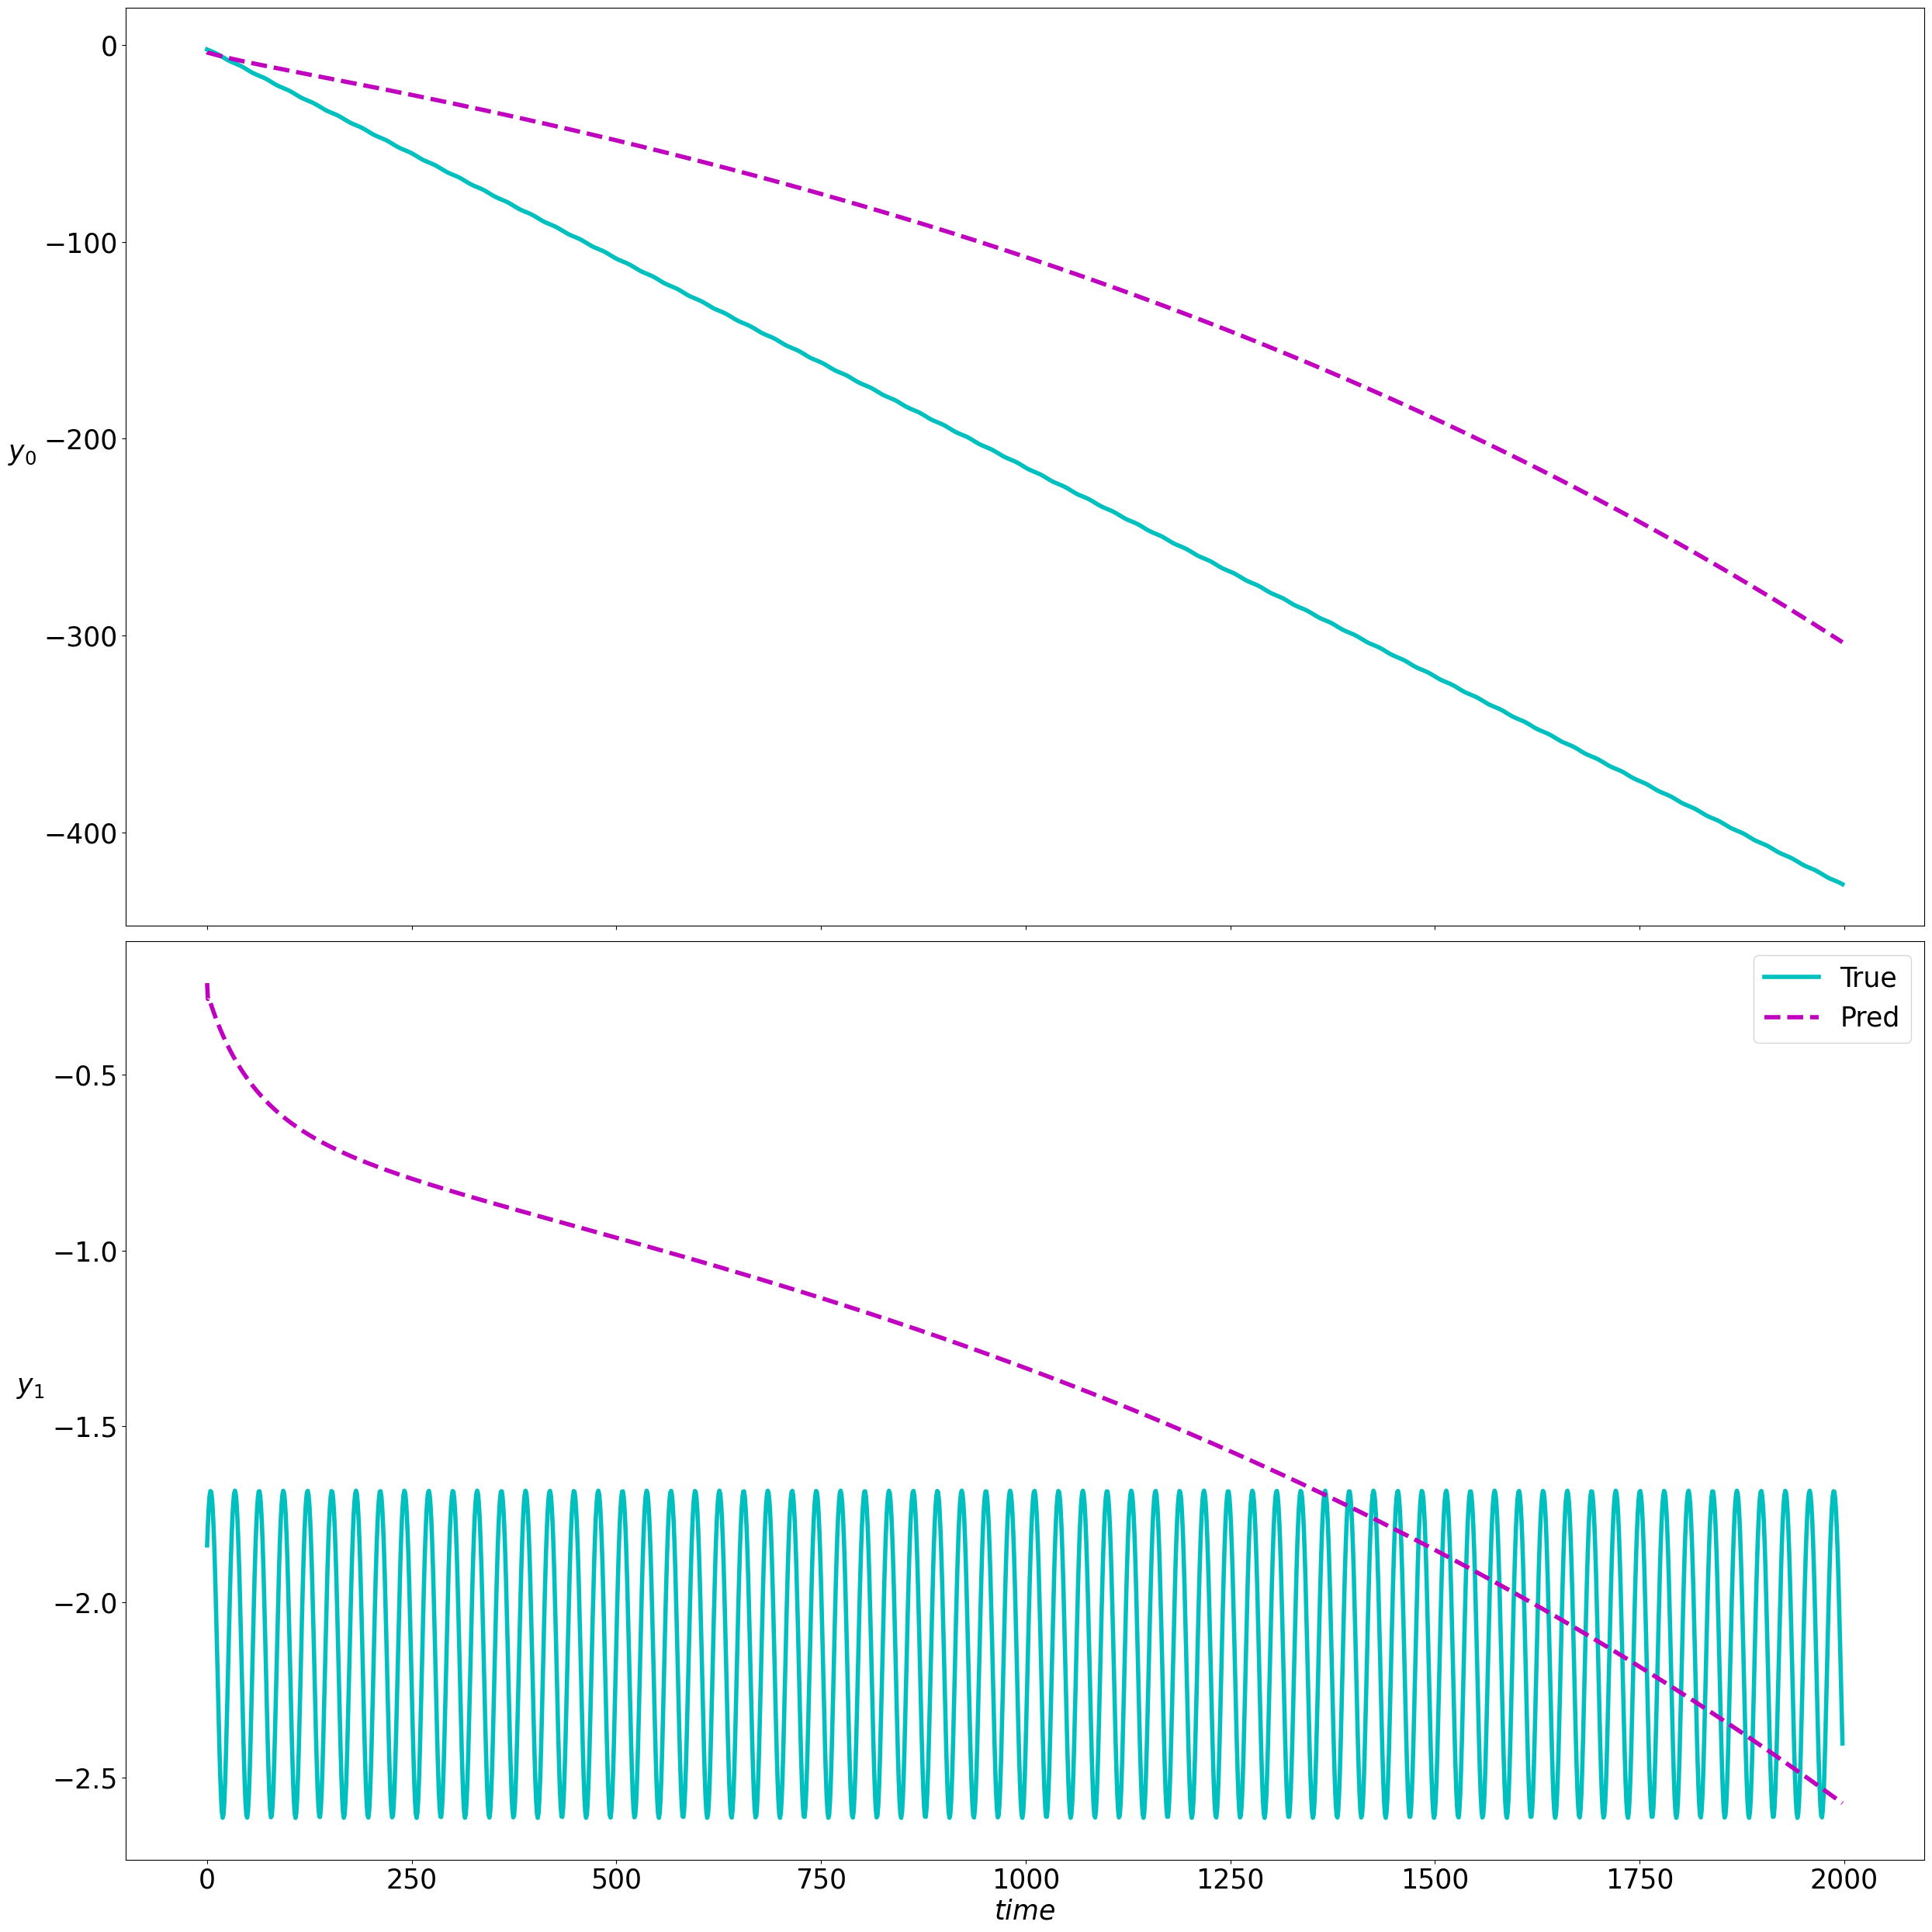

In [60]:
# plot trajectories
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

In [61]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eReal = eig.real.detach().numpy()
eImag = eig.imag.detach().numpy()
# unit circle
t = np.linspace(0.0, 2 * np.pi, 1000)
x_circ = np.cos(t)
y_circ = np.sin(t)

Text(0.5, 0.98, 'Koopman operator eigenvalues')

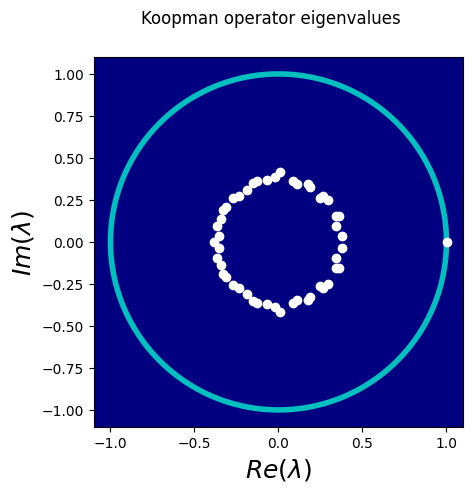

In [62]:
# plot Koopman eigenvalues
fig1, ax1 = plt.subplots()
ax1.plot(x_circ, y_circ, 'c', linewidth=4)
ax1.plot(eReal, eImag, 'wo')
ax1.set_aspect('equal', 'box')
ax1.set_facecolor("navy")
ax1.set_xlabel("$Re(\lambda)$", fontsize=18)
ax1.set_ylabel("$Im(\lambda)$", fontsize=18)
fig1.suptitle('Koopman operator eigenvalues')

In [63]:
# compute Koopman eigenvectors
y1 = torch.linspace(-2.2, 2.2, 1000)
y2 = torch.linspace(-2.2, 2.2, 1000)
yy1, yy2 = torch.meshgrid(y1, y1)
plot_yy1 = yy1.detach().numpy()
plot_yy2 = yy2.detach().numpy()
# eigenvectors
features = torch.stack([yy1, yy2]).transpose(0, 2)
latent = encode(features)
phi = torch.matmul(latent, abs(eig_vec))
# select first 6 eigenvectors
phi_1 = phi.detach().numpy()[:,:,0]
phi_2 = phi.detach().numpy()[:,:,1]
phi_3 = phi.detach().numpy()[:,:,2]
phi_4 = phi.detach().numpy()[:,:,3]
phi_5 = phi.detach().numpy()[:,:,4]
phi_6 = phi.detach().numpy()[:,:,6]

Text(0.5, 0.98, 'first six eigenfunctions')

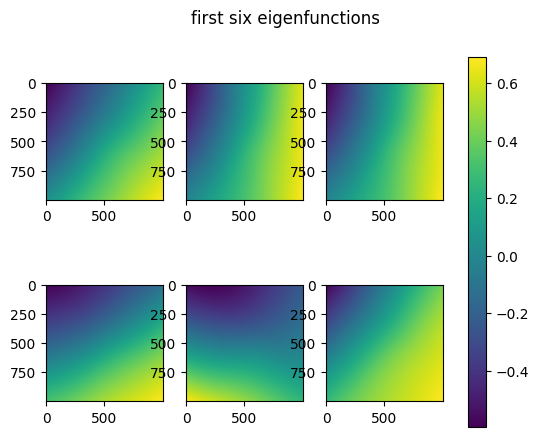

In [64]:
# plot eigenvectors
fig2, axs = plt.subplots(2, 3)
im1 = axs[0,0].imshow(phi_1)
im2 = axs[0,1].imshow(phi_2)
im3 = axs[0,2].imshow(phi_3)
im4 = axs[1,0].imshow(phi_4)
im5 = axs[1,1].imshow(phi_5)
im6 = axs[1,2].imshow(phi_6)
fig2.colorbar(im1, ax=axs)
fig2.suptitle('first six eigenfunctions')